In [1]:
import numpy as np
import pickle as pkl
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py
from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon
import os
# import sys
# sys.path.append('/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model')
from Model_utils import other_billeh_utils
import skimage.measure as skm
import scipy.ndimage as ndi
from joblib import Parallel, delayed
# os.chdir('..')

2025-02-11 17:58:13.931297: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 17:58:13.957710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Receptive Field Analysis Class

In [2]:
class ReceptiveFieldAnalysis:
    def __init__(self, data_file, initial_row, final_row, initial_col, final_col, radius_circle, significance_level=0.01, firing_rate_threshold=0.1, n_shuffles=1000, epsilon=1e-6):
        self.data_file = data_file
        # self.row_size = final_row - initial_row
        # self.col_size = final_col - initial_col
        self.radius_circle = radius_circle
        self.initial_azimuth = initial_col 
        self.final_azimuth = final_col
        self.initial_elevation = initial_row
        self.final_elevation = final_row
        self.significance_level = significance_level  # Significance level for the permutation test (default: 0.01)
        self.firing_rate_threshold = firing_rate_threshold
        self.n_shuffles = n_shuffles
        self.epsilon = epsilon

        # Calculate the grid size
        # self.n_rows = int(np.ceil((self.row_size - self.radius_circle) / self.radius_circle)) #13
        # self.n_cols = int(np.ceil((self.col_size - self.radius_circle) / self.radius_circle)) #11
        self.n_rows = final_row - initial_row
        self.n_cols = final_col - initial_col

        # Time bin configuration
        self.time_bins = np.array([[100, 350], [450, 700], [800, 1050]])
        self.n_timesteps = sum(end - start for start, end in self.time_bins)
        
    def identify_outliers(self, rf):
        """Create a binary map for the outliers using the interquartile method."""
        q1 = np.percentile(rf, 25)  # First quartile (25th percentile)
        q3 = np.percentile(rf, 75)  # Third quartile (75th percentile)
        iqr = q3 - q1
        # Define thresholds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Identify outliers
        above_outliers = rf[rf > upper_bound]
        below_outliers = rf[rf < lower_bound]
        return above_outliers, below_outliers

    def process_connected_components(self, binary_map):
        """Process connected components and find the largest one."""
        labeled_map = skm.label(binary_map)
        regions = skm.regionprops(labeled_map)
        if regions:
            largest_region = max(regions, key=lambda r: r.area)
            largest_map = (labeled_map == largest_region.label)
            positions = np.where(largest_map)
            return largest_map, positions
        return np.zeros_like(binary_map), ([], [])
    
    def get_largest_chi2_value(self, rf, binary_map):
        expected_value = np.mean(rf)
        # compute residuals
        original_residuals = (rf - expected_value)**2 / (expected_value + 1e-6)
        labels, num_features = ndi.label(binary_map)
        # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
        chi2_values = np.zeros(num_features)
        for i in range(1, num_features + 1):
            cluster_pixels = original_residuals[labels == i]
            chi2_values[i - 1] = np.sum(cluster_pixels)
        if len(chi2_values) == 0:
            return 0
        else:
            return np.max(chi2_values)

    def is_rf_inverted(self, rf):
        # Identify outliers using the IQR method
        above_outliers, below_outliers = self.identify_outliers(rf)
        # Create binary maps for outliers
        above_binary_map = np.isin(rf, above_outliers).astype(int)
        below_binary_map = np.isin(rf, below_outliers).astype(int)
        # get most significant cluster
        above_chi2 = self.get_largest_chi2_value(rf, above_binary_map)
        below_chi2 = self.get_largest_chi2_value(rf, below_binary_map)
        # Compare chi2 values of above and below outliers
        return below_chi2 > above_chi2

        # # Process connected components
        # _, above_positions = self.process_connected_components(above_binary_map)
        # _, below_positions = self.process_connected_components(below_binary_map)
        # # Return True if the number of below-outlier positions is greater than the number of above-outlier positions, 
        # # indicating an inverted RF
        # return len(below_positions[0]) > len(above_positions[0])

    def invert_rf(self, rf):
        """Creates an inverted version of the receptive field

        Parameters
        ----------
        rf - matrix of spike counts at each stimulus position

        Returns
        -------
        rf_inverted - new RF matrix

        """
        return np.max(rf) - rf

    def convert_elevation_to_degrees(self, elevation_in_pixels, elevation_offset_degrees=10, degrees_to_pixels_ratio=10):
        """Converts a pixel-based elevation into degrees relative to
        center of gaze

        The receptive field computed by this class is oriented such
        that the pixel values are in the correct relative location
        when using matplotlib.pyplot.imshow(), which places (0,0)
        in the upper-left corner of the figure.

        Therefore, we need to invert the elevation value prior
        to converting to degrees.

        Parameters
        ----------
        elevation_in_pixels : float
        elevation_offset_degrees: float

        Returns
        -------
        elevation_in_degrees : float
        """
        # elevation_in_degrees = (
        #     self.convert_pixels_to_degrees(self.n_rows - 1 - elevation_in_pixels)
        #     + elevation_offset_degrees
        # )
        elevation_in_degrees = (
            self.convert_pixels_to_degrees(elevation_in_pixels, degrees_to_pixels_ratio=degrees_to_pixels_ratio) + elevation_offset_degrees
        )
        return elevation_in_degrees

    def convert_azimuth_to_degrees(self, azimuth_in_pixels, azimuth_offset_degrees=10, degrees_to_pixels_ratio=10):
        """Converts a pixel-based azimuth into degrees relative
        to center of gaze

        Parameters
        ----------
        azimuth_in_pixels : float
        azimuth_offset_degrees: float

        Returns
        -------
        azimuth_in_degrees : float
        """
        azimuth_in_degrees = (
            self.convert_pixels_to_degrees(azimuth_in_pixels, degrees_to_pixels_ratio=degrees_to_pixels_ratio) + azimuth_offset_degrees
        )
        return azimuth_in_degrees

    def convert_pixels_to_degrees(self, value_in_pixels, degrees_to_pixels_ratio=10):
        """Converts a pixel-based distance into degrees

        Parameters
        ----------
        value_in_pixels : float
        degrees_to_pixels_ratio: float

        Returns
        -------
        value in degrees : float
        """
        return value_in_pixels * degrees_to_pixels_ratio

    def convert_pixel_area_to_degrees(self, area_in_pixels, degrees_to_pixels_ratio=10):
        """Converts a pixel-based area measure into degrees

        Each pixel is a square with side of length
        <degrees_to_pixels_ratio>

        So the area in degrees is
        area_in_pixels * <degrees to_pixels_ratio>^2

        Parameters
        ----------
        area_in_pixels : float

        Returns
        -------
        area_in_degrees : float
        """
        return area_in_pixels * pow(self.convert_pixels_to_degrees(1, degrees_to_pixels_ratio=degrees_to_pixels_ratio), 2)

    def get_rf_stats(self, spike_counts, firing_rates, neuron_id):
        """Calculate a variety of metrics for one unit's receptive field

        Parameters
        ----------
        neuron_id : int
            unique ID for the unit of interest
        spike_counts : np.ndarray
            3D array of total spike counts among trials for each unit at each location
        firing_rates : np.ndarray
            3D array of firing rates among trials for each unit at each location

        Returns
        -------
        azimuth :
            preferred azimuth in degrees, based on center of mass
            of thresholded RF
        elevation :
            preferred elevation in degrees, based on center of mass
            of thresholded RF
        area :
            receptive field area in degrees^2, based on thresholded
            RF area
        inverse_rf :
            boolean indicating whether the RF is inverted
        """
        average_firing_rate = firing_rates[:,:,neuron_id] 
        total_spike_count = spike_counts[:,:,neuron_id] 
        
        if np.mean(average_firing_rate) < self.firing_rate_threshold:
            # print(f'Neuron {neuron_id} has a low firing rate, select another neuron')
            return np.nan, np.nan, np.nan, np.nan

        # Apply the Gaussian filter to the total spike count
        rf_filt = ndi.gaussian_filter(total_spike_count, 1)

        # Check if the RF is inverted and invert it if necessary
        if self.is_rf_inverted(total_spike_count):
            inverse_rf = True
            rf_filt = self.invert_rf(rf_filt)
        else:
            inverse_rf = False

        # Apply a threshold to the filtered RF
        threshold_value = np.max(rf_filt) - np.std(rf_filt)
        rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
        rf_thresh[rf_filt > threshold_value] = True

        # Perform connected component analysis to find the strongest/largest connected component which we identify as the RF
        labels, num_features = ndi.label(rf_thresh)
        expected_value = np.mean(total_spike_count)
        # compute residuals
        original_residuals = (total_spike_count - expected_value)**2 / (expected_value + 1e-6)
        # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
        chi2_values = np.zeros(num_features)
        for i in range(1, num_features + 1):
            cluster_pixels = original_residuals[labels == i]
            chi2_values[i - 1] = np.sum(cluster_pixels)

        # If no clusters found, return NaN for azimuth, elevation, area, and inverted RF
        if len(chi2_values) <= 0:
            # print("No clusters found in the RF for neuron", neuron_id)
            return np.nan, np.nan, np.nan, np.nan

        best_cluster_index = np.argmax(chi2_values) + 1
        # strongest_label = np.argmax(ndi.maximum(rf_filt, labels=labels, index=np.unique(labels)))
        # largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

        best_label = best_cluster_index
        labels[labels != best_label] = 0
        labels[labels > 0] = 1

        # Compute the center of mass and area of the RF
        center_y, center_x = ndi.center_of_mass(labels) # this center is located in the upper left corner of the pixel
        center_x = np.around(center_x, 4) + self.initial_azimuth
        center_y = np.around(center_y, 4) + self.initial_elevation
        center_azimuth = self.convert_azimuth_to_degrees(center_x, degrees_to_pixels_ratio=self.radius_circle)
        center_elevation = self.convert_elevation_to_degrees(center_y, degrees_to_pixels_ratio=self.radius_circle)

        # Compute the area of the RF in pixels and convert it to degrees
        pixels_area = float(np.sum(labels))
        rf_area = self.convert_pixel_area_to_degrees(pixels_area, degrees_to_pixels_ratio=self.radius_circle)

        # Check if the RF area is too large or too small        
        if rf_area > 2500 or rf_area <= 0:
            return np.nan, np.nan, np.nan, np.nan

        return center_azimuth, center_elevation, rf_area, inverse_rf

    def single_neuron_chi2(self, neuron_index, spikes, indices):
        """Compute the chi-square statistic for a single neuron using a categorical chi-square test."""
        neuron_rf_trials = spikes[:, :, :, neuron_index].reshape(-1).astype(np.float32)
        # Create n_shuffles bootstrap samples 
        bootstrap_samples = neuron_rf_trials[indices].reshape(self.n_shuffles, self.n_rows, self.n_cols, self.n_trials)
        shuffled_rf = bootstrap_samples.sum(axis=3, dtype=np.float32)
        # Compute the expected and residuals for each bootstrap sample
        shuffled_expected = np.mean(shuffled_rf, axis=(1, 2))
        residuals = (shuffled_rf - shuffled_expected[:, np.newaxis, np.newaxis]) ** 2
        shuffled_chi2 = np.sum(
            residuals / (shuffled_expected[:, np.newaxis, np.newaxis] + self.epsilon),
            axis=(1, 2)
        )
        return shuffled_chi2

    def compute_rf_pvalue(self, spikes, total_spikes):
        """Compute the p-value for the RF significance using a categorical chi-square test."""	
        sample_size = self.n_rows * self.n_cols * self.n_trials
        # Precompute the real chi^2 for each neuron
        expected = np.mean(total_spikes.astype(np.float32), axis=(0, 1))
        residuals = (total_spikes - expected[None, None, :]) ** 2
        real_chi2 = np.sum(residuals / (expected[None, None, :] + self.epsilon), axis=(0,1))
        # Compute the shuffled chi^2 values
        rng = np.random.default_rng()
        indices = rng.integers(0, sample_size, size=(self.n_shuffles, sample_size))
        shuffled_chi2 = Parallel(n_jobs=-1)(
            delayed(self.single_neuron_chi2)(neuron_index, spikes, indices)
            for neuron_index in tqdm(range(self.n_units))
        )
        # Compute the p-value as the fraction of the shuffled chi^2 values exceeding the real chi^2 value for each neuron
        p_value = np.mean(shuffled_chi2 > real_chi2[:, None], axis=1)
        return p_value

    def __call__(self, area):
        # Load the data for all trials and locations
        with h5py.File(self.data_file, 'r') as data:
            name = list(data['Data'][area].keys())[0]
            self.n_trials, self.n_units = data['Data'][area][name][:].shape

        print(f'Loading data for {area}...')
        spikes = np.zeros((self.n_rows, self.n_cols, self.n_trials, self.n_units), dtype=np.float32) # sum of all spikes per neuron and position
        with h5py.File(self.data_file, 'r') as data:
            # for col in tqdm(range(self.n_cols)):
            for col_idx, col in tqdm(enumerate(range(self.initial_azimuth, self.final_azimuth))):
                # for row in range(self.n_rows):
                for row_idx, row in enumerate(range(self.initial_elevation, self.final_elevation)):
                    name = str(row)+'_'+str(col)
                    spikes[row_idx, col_idx, :, :] = np.array(data['Data'][area][name][:], dtype=np.float32)

        # Get the total spike count and firing rates for each neuron
        total_spikes = np.sum(spikes, axis=2)
        firing_rates = total_spikes / (self.n_trials * self.n_timesteps) * 1000

        # Compute RF stats for each neuron
        print(f'Computing RF stats for {area}...')
        rf_areas = np.zeros((self.n_units))
        center_of_mass = np.zeros((self.n_units, 2))
        inverse_rfs = np.zeros((self.n_units))
        for neuron_id in tqdm(range(self.n_units)):
            center_azimuth, center_elevation, rf_area, inverse_rf = self.get_rf_stats(total_spikes, firing_rates, neuron_id)
            rf_areas[neuron_id] = rf_area
            center_of_mass[neuron_id, :] = center_azimuth, center_elevation
            inverse_rfs[neuron_id] = inverse_rf

        # Compute p-values for RF significance
        print(f'Computing RF p-values for {area}...')
        rf_p_value = self.compute_rf_pvalue(spikes, total_spikes)
        # replace with nan the rf fields with non significant values
        rf_areas[rf_p_value > self.significance_level] = np.nan
        center_of_mass[rf_p_value > self.significance_level] = np.nan
        inverse_rfs[rf_p_value > self.significance_level] = np.nan
        print(f'Fraction of neurons with p-value < {self.significance_level}:', np.sum(rf_p_value < 0.01) / self.n_units)

        return rf_areas, center_of_mass, inverse_rfs, rf_p_value
        # return rf_areas, center_of_mass, inverse_rfs, np.zeros((self.n_units))

# Example Usage

In [3]:
# Constants
COL_SIZE = 240
ROW_SIZE = 120
RADIUS_CIRCLE = 5 # 10
N_SHUFFLES = 10
N_CORE_NEURONS_V1 = 51978
N_CORE_NEURONS_LM = 7414
LM_TO_V1_RADIUS_RATIO = 400 / 151.07
CACHE_PATH = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
RESULTS_PATH = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_gvbz/Best_model/ckpt-240_results'
# RESULTS_PATH = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_gvbz_mnist/Best_model/ckpt-12_results'
CONNECTED_RESULTS_PATH = os.path.join(RESULTS_PATH, 'connected_areas_True_conn_rec_True_conn_noise_True')
# DISCONNECTED_RESULTS_PATH = os.path.join(RESULTS_PATH, 'connected_areas_True_conn_rec_False_conn_noise_True')
DISCONNECTED_RESULTS_PATH = os.path.join(RESULTS_PATH, 'connected_areas_False_conn_rec_True_conn_noise_True')

In [4]:
# Load network parameters
with open(CACHE_PATH, 'rb') as f:
    networks, lgn_inputs, _ = pkl.load(f)

n_rows = int(np.ceil((ROW_SIZE - RADIUS_CIRCLE) / RADIUS_CIRCLE)) #13
n_cols = int(np.ceil((COL_SIZE - RADIUS_CIRCLE) / RADIUS_CIRCLE)) #11

# Load the LGN units data for find the extreme possible values for the RF locations
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/lgn_model/data/lgn_full_col_cells_240x120.csv'
lgn_data = pd.read_csv(path, sep=' ')

# Get the extreme locations of the lgn connected neurons
lgn_ids = np.array(list(set(lgn_inputs['v1']['indices'][:, 1])))
x, y = lgn_data['x'][lgn_ids].values, lgn_data['y'][lgn_ids].values
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

# using the min_x and max_x, calculate the real initial and final row for iteration
INITIAL_ROW = int((min_y - RADIUS_CIRCLE) / RADIUS_CIRCLE)
FINAL_ROW = int(max_y / RADIUS_CIRCLE) + 1
# same for the columns
INITIAL_COL = int((min_x - RADIUS_CIRCLE) / RADIUS_CIRCLE)
FINAL_COL = int(max_x / RADIUS_CIRCLE) + 1

# calculate the total number of columns
total_cols = FINAL_COL - INITIAL_COL
total_rows = FINAL_ROW - INITIAL_ROW

total_simulations = total_cols * total_rows
n_raw_simulations = n_rows * n_cols

# n_cols, total_cols, n_rows, total_rows
min_x, max_x, INITIAL_COL, FINAL_COL, n_cols, total_cols

(58.2204704284668, 183.3488006591797, 10, 37, 47, 27)

In [5]:
min_y, max_y, INITIAL_ROW, FINAL_ROW, n_rows, total_rows

(19.026386260986328, 101.44417572021484, 2, 21, 23, 19)

In [6]:
total_simulations, n_raw_simulations

(513, 1081)

In [7]:
### ADD VISUAL COORDINATES TO THE FEATURES CSV ###

# Helper function to compute visual coordinates
def compute_visual_coordinates(network, core_mask, radius_ratio=1.0):
    azimuth = network['x'][core_mask] * radius_ratio * 70 / 1000 + 120
    elevation = network['z'][core_mask] * radius_ratio * 40 / 1000 + 60
    return azimuth, elevation

# Load network parameters
with open(CACHE_PATH, 'rb') as f:
    networks, lgn_inputs, _ = pkl.load(f)

# Process V1 Network
v1_core_mask = other_billeh_utils.isolate_core_neurons(networks['v1'], n_selected_neurons=N_CORE_NEURONS_V1, data_dir='GLIF_network')
v1_azimuth, v1_elevation = compute_visual_coordinates(networks['v1'], v1_core_mask)

# Update V1 DataFrame
df_v1_path = os.path.join(CONNECTED_RESULTS_PATH, "v1_features_df.csv")
# check if the dataframe already exists, if not, create it
if not os.path.isfile(df_v1_path):
    df_v1 = pd.DataFrame(columns=['Mapped_azimuth', 'Mapped_elevation'])
    df_v1['pop_name'] = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=N_CORE_NEURONS_V1, data_dir='GLIF_network')
    df_v1['node_id'] = np.arange(N_CORE_NEURONS_V1)
else:
    df_v1 = pd.read_csv(df_v1_path, delimiter=' ')

# read or create the dataframe
df_v1['Mapped_azimuth'] = v1_azimuth
df_v1['Mapped_elevation'] = v1_elevation
df_v1.to_csv(df_v1_path, index=False, sep=' ')

# Process LM Network
lm_core_mask = other_billeh_utils.isolate_core_neurons(networks['lm'], n_selected_neurons=N_CORE_NEURONS_LM, data_dir='GLIF_network')
lm_azimuth, lm_elevation = compute_visual_coordinates(networks['lm'], lm_core_mask, radius_ratio=LM_TO_V1_RADIUS_RATIO)

# Update LM DataFrame
df_lm_path = os.path.join(CONNECTED_RESULTS_PATH, "lm_features_df.csv")
# check if the dataframe already exists, if not, create it
if not os.path.isfile(df_lm_path):
    df_lm = pd.DataFrame(columns=['Mapped_azimuth', 'Mapped_elevation'])
    df_lm['pop_name'] = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=N_CORE_NEURONS_LM, data_dir='GLIF_network')
    df_lm['node_id'] = np.arange(N_CORE_NEURONS_LM)
else:
    df_lm = pd.read_csv(df_lm_path, delimiter=' ')

df_lm['Mapped_azimuth'] = lm_azimuth
df_lm['Mapped_elevation'] = lm_elevation
df_lm.to_csv(df_lm_path, index=False, sep=' ')

In [8]:
### CALCULATE RF STATS FOR CONNECTED NETWORK ###
# DATA_FILE = os.path.join(CONNECTED_RESULTS_PATH, 'Receptive_field_10x10/Data/simulation_data.hdf5')
DATA_FILE = os.path.join(CONNECTED_RESULTS_PATH, 'Receptive_field/Data/simulation_data.hdf5')

# rf_analysis = ReceptiveFieldAnalysis(DATA_FILE, ROW_SIZE, COL_SIZE, RADIUS_CIRCLE, n_shuffles=N_SHUFFLES)
rf_analysis = ReceptiveFieldAnalysis(DATA_FILE, INITIAL_ROW, FINAL_ROW, INITIAL_COL, FINAL_COL, RADIUS_CIRCLE, n_shuffles=N_SHUFFLES)

rf_areas_v1, center_of_mass_v1, inverse_rfs_v1, rf_p_value_v1 = rf_analysis('v1')
rf_areas_lm, center_of_mass_lm, inverse_rfs_lm, rf_p_value_lm = rf_analysis('lm')
# rf_areas_lgn, center_of_mass_lgn, inverse_rfs_lgn, rf_p_value_lgn = rf_analysis('LGN')

# Load and include the csv with data
df_v1 = pd.read_csv(os.path.join(CONNECTED_RESULTS_PATH, "v1_features_df.csv"), delimiter=' ')
df_lm = pd.read_csv(os.path.join(CONNECTED_RESULTS_PATH, "lm_features_df.csv"), delimiter=' ')
# add a column to df_v1 with the RF areas
df_v1['RF_area'] = rf_areas_v1
df_lm['RF_area'] = rf_areas_lm
# add center of mass position
df_v1['RF_center_azimuth'] = center_of_mass_v1[:, 0]
df_v1['RF_center_elevation'] = center_of_mass_v1[:, 1]
df_lm['RF_center_azimuth'] = center_of_mass_lm[:, 0]
df_lm['RF_center_elevation'] = center_of_mass_lm[:, 1]
# add inverse RF or not as True or False depending if the index is in the inverse_indices list
df_v1['Inverse_RF'] = inverse_rfs_v1
df_lm['Inverse_RF'] = inverse_rfs_lm
# add p-values
df_v1['RF_p_value'] = rf_p_value_v1
df_lm['RF_p_value'] = rf_p_value_lm
# save the dataframes
df_v1.to_csv(os.path.join(CONNECTED_RESULTS_PATH, f"v1_features_df.csv"), sep=' ', index=False)
df_lm.to_csv(os.path.join(CONNECTED_RESULTS_PATH, f"lm_features_df.csv"), sep=' ', index=False)

Loading data for v1...


0it [00:00, ?it/s]

27it [00:17,  1.57it/s]


Computing RF stats for v1...


100%|██████████| 51978/51978 [00:14<00:00, 3524.44it/s]


Computing RF p-values for v1...


100%|██████████| 51978/51978 [00:32<00:00, 1614.17it/s]


Fraction of neurons with p-value < 0.01: 0.3635768979183501
Loading data for lm...


27it [00:02, 10.34it/s]


Computing RF stats for lm...


100%|██████████| 7414/7414 [00:02<00:00, 3529.21it/s]


Computing RF p-values for lm...


100%|██████████| 7414/7414 [00:01<00:00, 4599.33it/s]


Fraction of neurons with p-value < 0.01: 0.10331804693822498


In [9]:
# Count the number of inverse neurons
num_inverse_v1 = df_v1[df_v1['Inverse_RF'] == True].shape[0]
num_non_inverse_v1 = df_v1[df_v1['Inverse_RF'] == False].shape[0]
num_inverse_lm = df_lm[df_lm['Inverse_RF'] == True].shape[0]
num_non_inverse_lm = df_lm[df_lm['Inverse_RF'] == False].shape[0]

# Print the useful information
print(f"Number of inverse neurons in V1: {num_inverse_v1}")
print(f"Number of non-inverse neurons in V1: {num_non_inverse_v1}")
print(f"Number of inverse neurons in LM: {num_inverse_lm}")
print(f"Number of non-inverse neurons in LM: {num_non_inverse_lm}")

## Count the number of non-NaN receptive field areas
num_non_nan_rf_area_v1 = df_v1[~df_v1['RF_area'].isnull()].shape[0]
num_non_nan_rf_area_lm = df_lm[~df_lm['RF_area'].isnull()].shape[0]

# Print the useful information
print(f"Number of significant receptive field areas in V1: {num_non_nan_rf_area_v1}/{N_CORE_NEURONS_V1}")
print(f"Number of significant receptive field areas in LM: {num_non_nan_rf_area_lm}/{N_CORE_NEURONS_LM}")

Number of inverse neurons in V1: 2128
Number of non-inverse neurons in V1: 16769
Number of inverse neurons in LM: 180
Number of non-inverse neurons in LM: 584
Number of significant receptive field areas in V1: 18897/51978
Number of significant receptive field areas in LM: 764/7414


In [10]:
    # Number of inverse neurons in V1: 4773
    # Number of non-inverse neurons in V1: 29882
    # Number of inverse neurons in LM: 252
    # Number of non-inverse neurons in LM: 2190
    # Number of significant receptive field areas in V1: 34655/51978
    # Number of significant receptive field areas in LM: 2442/7414

In [11]:
### CALCULATE RF STATS FOR DISCONNECTED NETWORK ###
DATA_FILE = os.path.join(DISCONNECTED_RESULTS_PATH, 'Receptive_field/Data/simulation_data.hdf5')
# rf_analysis = ReceptiveFieldAnalysis(DATA_FILE, ROW_SIZE, COL_SIZE, RADIUS_CIRCLE, n_shuffles=N_SHUFFLES)
rf_analysis = ReceptiveFieldAnalysis(DATA_FILE, INITIAL_ROW, FINAL_ROW, INITIAL_COL, FINAL_COL, RADIUS_CIRCLE, n_shuffles=N_SHUFFLES)

rf_areas_v1, center_of_mass_v1, inverse_rfs_v1, rf_p_value_v1 = rf_analysis('v1')
rf_areas_lm, center_of_mass_lm, inverse_rfs_lm, rf_p_value_lm = rf_analysis('lm')
# rf_areas_lgn, center_of_mass_lgn, inverse_rfs_lgn, rf_p_value_lgn = rf_analysis('LGN')

# check if the dataframe already exists, if not, create it
if not os.path.isfile(os.path.join(DISCONNECTED_RESULTS_PATH, "v1_features_df.csv")):
    df_v1 = pd.DataFrame(columns=['Mapped_azimuth', 'Mapped_elevation'])
    df_v1['pop_name'] = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=N_CORE_NEURONS_V1, data_dir='GLIF_network')
    df_v1['node_id'] = np.arange(N_CORE_NEURONS_V1)
else:
    df_v1 = pd.read_csv(os.path.join(DISCONNECTED_RESULTS_PATH, "v1_features_df.csv"), delimiter=' ')
if not os.path.isfile(os.path.join(DISCONNECTED_RESULTS_PATH, "lm_features_df.csv")):
    df_lm = pd.DataFrame(columns=['Mapped_azimuth', 'Mapped_elevation'])
    df_lm['pop_name'] = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=N_CORE_NEURONS_LM, data_dir='GLIF_network')
    df_lm['node_id'] = np.arange(N_CORE_NEURONS_LM)
else:
    df_lm = pd.read_csv(os.path.join(DISCONNECTED_RESULTS_PATH, "lm_features_df.csv"), delimiter=' ')
    
# add a column to df_v1 with the RF areas
df_v1['RF_area'] = rf_areas_v1
df_lm['RF_area'] = rf_areas_lm
# add center of mass position
df_v1['RF_center_azimuth'] = center_of_mass_v1[:, 0]
df_v1['RF_center_elevation'] = center_of_mass_v1[:, 1]
df_lm['RF_center_azimuth'] = center_of_mass_lm[:, 0]
df_lm['RF_center_elevation'] = center_of_mass_lm[:, 1]
# add inverse RF or not as True or False depending if the index is in the inverse_indices list
df_v1['Inverse_RF'] = inverse_rfs_v1
df_lm['Inverse_RF'] = inverse_rfs_lm
# add p-values
df_v1['RF_p_value'] = rf_p_value_v1
df_lm['RF_p_value'] = rf_p_value_lm
# save the dataframes
df_v1.to_csv(os.path.join(DISCONNECTED_RESULTS_PATH, f"v1_features_df.csv"), sep=' ', index=False)
df_lm.to_csv(os.path.join(DISCONNECTED_RESULTS_PATH, f"lm_features_df.csv"), sep=' ', index=False)

Loading data for v1...


0it [00:00, ?it/s]

27it [00:17,  1.56it/s]


Computing RF stats for v1...


100%|██████████| 51978/51978 [00:13<00:00, 3945.91it/s]


Computing RF p-values for v1...


100%|██████████| 51978/51978 [00:56<00:00, 927.30it/s] 


Fraction of neurons with p-value < 0.01: 0.42156296894840123
Loading data for lm...


27it [00:02, 11.48it/s]


Computing RF stats for lm...


100%|██████████| 7414/7414 [00:00<00:00, 13324.50it/s]


Computing RF p-values for lm...


100%|██████████| 7414/7414 [00:01<00:00, 5750.63it/s]


Fraction of neurons with p-value < 0.01: 0.43215538171027784


In [12]:
# Count the number of inverse neurons
num_inverse_v1 = df_v1[df_v1['Inverse_RF'] == True].shape[0]
num_non_inverse_v1 = df_v1[df_v1['Inverse_RF'] == False].shape[0]
num_inverse_lm = df_lm[df_lm['Inverse_RF'] == True].shape[0]
num_non_inverse_lm = df_lm[df_lm['Inverse_RF'] == False].shape[0]

# Print the useful information
print(f"Number of inverse neurons in V1: {num_inverse_v1}")
print(f"Number of non-inverse neurons in V1: {num_non_inverse_v1}")
print(f"Number of inverse neurons in LM: {num_inverse_lm}")
print(f"Number of non-inverse neurons in LM: {num_non_inverse_lm}")

## Count the number of non-NaN receptive field areas
num_non_nan_rf_area_v1 = df_v1[~df_v1['RF_area'].isnull()].shape[0]
num_non_nan_rf_area_lm = df_lm[~df_lm['RF_area'].isnull()].shape[0]

# Print the useful information
print(f"Number of significant receptive field areas in V1: {num_non_nan_rf_area_v1}/{N_CORE_NEURONS_V1}")
print(f"Number of significant receptive field areas in LM: {num_non_nan_rf_area_lm}/{N_CORE_NEURONS_LM}")

Number of inverse neurons in V1: 1544
Number of non-inverse neurons in V1: 19191
Number of inverse neurons in LM: 32
Number of non-inverse neurons in LM: 90
Number of significant receptive field areas in V1: 20735/51978
Number of significant receptive field areas in LM: 122/7414


# Analysis of significant RFs

In [13]:
# Load and include the csv with data
df_v1 = pd.read_csv(os.path.join(CONNECTED_RESULTS_PATH, "v1_features_df.csv"), delimiter=' ')
df_lm = pd.read_csv(os.path.join(CONNECTED_RESULTS_PATH, "lm_features_df.csv"), delimiter=' ')
df_v1_dis = pd.read_csv(os.path.join(DISCONNECTED_RESULTS_PATH, "v1_features_df.csv"), delimiter=' ')
df_lm_dis = pd.read_csv(os.path.join(DISCONNECTED_RESULTS_PATH, "lm_features_df.csv"), delimiter=' ')

# for each cell type compute the fraction of neurons with non nan receptive fields
df_v1['cell_type'] = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in df_v1['pop_name']]
df_lm['cell_type'] = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in df_lm['pop_name']]
df_v1_dis['cell_type'] = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in df_v1_dis['pop_name']]

# Load the LGN units data for find the extreme possible values for the RF locations
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/lgn_model/data/lgn_full_col_cells_240x120.csv'
lgn_data = pd.read_csv(path, sep=' ')

# Get the extreme locations of the lgn connected neurons
lgn_ids = np.array(list(set(lgn_inputs['v1']['indices'][:, 1])))
x, y = lgn_data['x'][lgn_ids].values, lgn_data['y'][lgn_ids].values
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

# Remove significant neurons with RF center outside the limits of V1 RF
df_v1['RF_area'][(df_v1['RF_center_azimuth']<min_x) | (df_v1['RF_center_azimuth']>max_x)] = np.nan
df_v1['RF_area'][(df_v1['RF_center_elevation']<min_y) | (df_v1['RF_center_elevation']>max_y)] = np.nan

df_lm['RF_area'][(df_lm['RF_center_azimuth']<min_x) | (df_lm['RF_center_azimuth']>max_x)] = np.nan
df_lm['RF_area'][(df_lm['RF_center_elevation']<min_y) | (df_lm['RF_center_elevation']>max_y)] = np.nan

df_v1_dis['RF_area'][(df_v1_dis['RF_center_azimuth']<min_x) | (df_v1_dis['RF_center_azimuth']>max_x)] = np.nan
df_v1_dis['RF_area'][(df_v1_dis['RF_center_elevation']<min_y) | (df_v1_dis['RF_center_elevation']>max_y)] = np.nan

df_lm_dis['RF_area'][(df_lm_dis['RF_center_azimuth']<min_x) | (df_lm_dis['RF_center_azimuth']>max_x)] = np.nan
df_lm_dis['RF_area'][(df_lm_dis['RF_center_elevation']<min_y) | (df_lm_dis['RF_center_elevation']>max_y)] = np.nan

/tmp/ipykernel_1412966/654312216.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_v1['RF_area'][(df_v1['RF_center_azimuth']<min_x) | (df_v1['RF_center_azimuth']>max_x)] = np.nan
/tmp/ipykernel_1412966/654312216.py:23: SettingWithCopyW

58.2204704284668 183.3488006591797 19.026386260986328 101.44417572021484


Text(0.5, 1.0, 'v1 Neurons in LGN Field')

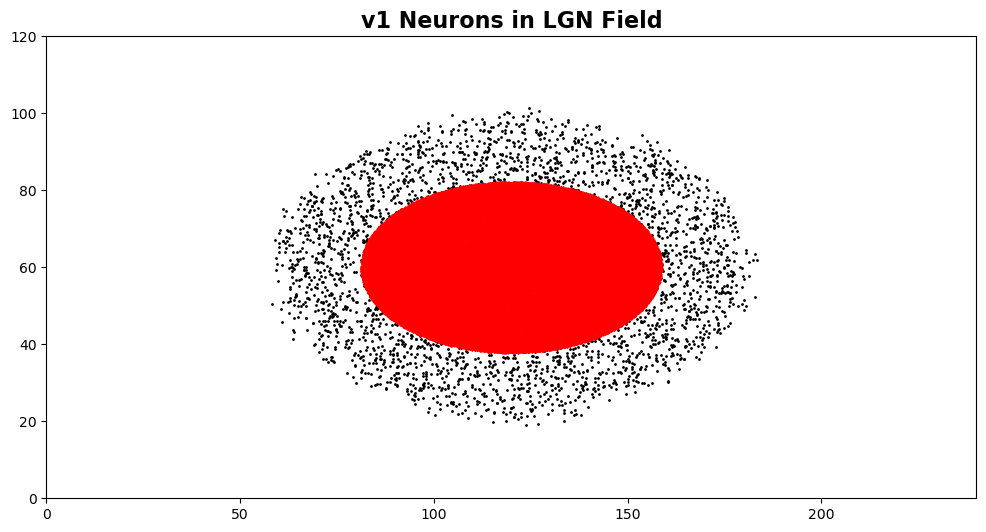

In [14]:
print(min_x, max_x, min_y, max_y)
area = 'v1'

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the LGN
ax.scatter(x, y, s=1, color='k')
ax.set_xlim(0, 240)
ax.set_ylim(0, 120)

# Plot the V1 neurons
x_neuron, y_neuron = networks[area]['x'] * 70/1000 + 120, networks['v1']['z'] * 40/1000 + 60
ax.scatter(x_neuron, y_neuron, s=0.3, color='red')

ax.set_title(f'{area} Neurons in LGN Field', fontsize=16, weight='bold')

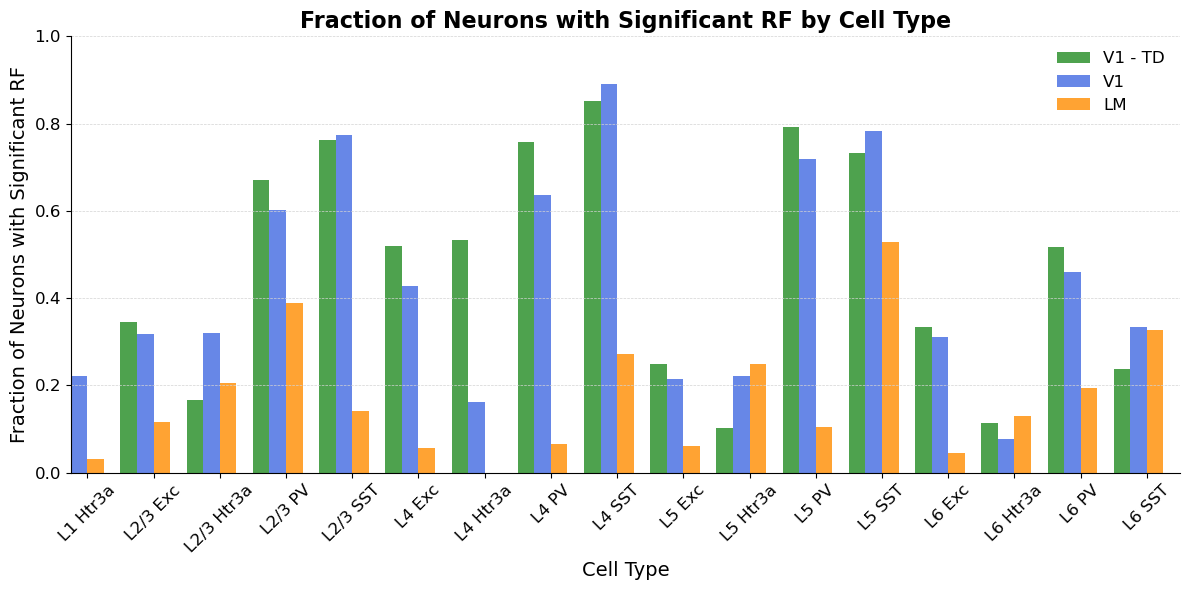

In [15]:
# Prepare the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Compute the fraction of neurons with non nan receptive fields
fraction_v1 = df_v1.groupby('cell_type')['RF_area'].apply(lambda x: np.sum(~np.isnan(x)) / len(x))
fraction_lm = df_lm.groupby('cell_type')['RF_area'].apply(lambda x: np.sum(~np.isnan(x)) / len(x))
fraction_v1_dis = df_v1_dis.groupby('cell_type')['RF_area'].apply(lambda x: np.sum(~np.isnan(x)) / len(x))

# Plot the fractions with better formatting
fraction_v1_dis.plot(kind='bar', ax=ax, color='forestgreen', alpha=0.8, label='V1 - TD', width=0.25, position=2)
fraction_v1.plot(kind='bar', ax=ax, color='royalblue', alpha=0.8, label='V1', width=0.25, position=1)
fraction_lm.plot(kind='bar', ax=ax, color='darkorange', alpha=0.8, label='LM', width=0.25, position=0)

# Enhance the aesthetics
ax.set_ylabel('Fraction of Neurons with Significant RF', fontsize=14)
ax.set_xlabel('Cell Type', fontsize=14)
ax.set_title('Fraction of Neurons with Significant RF by Cell Type', fontsize=16, weight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12, loc='upper right', frameon=False)
ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 1)

plt.tight_layout()
# save the figure
plt.savefig(os.path.join(RESULTS_PATH, 'fraction_neurons_with_significant_rf.png'))
plt.show()

In [16]:
# Remove all neurons with nan RF area
df_v1 = df_v1.dropna(subset=['RF_area'])
df_lm = df_lm.dropna(subset=['RF_area'])
df_v1_dis = df_v1_dis.dropna(subset=['RF_area'])
df_lm_dis = df_lm_dis.dropna(subset=['RF_area'])

In [17]:
# sort the neurons by RF_center_azimuth
# df_v1.sort_values(by='RF_center_azimuth')

In [18]:
error_azimuth = np.abs(df_v1['RF_center_azimuth'] - df_v1['Mapped_azimuth'])
error_elevation = np.abs(df_v1['RF_center_elevation'] - df_v1['Mapped_elevation'])
total_error = np.sqrt(error_azimuth**2 + error_elevation**2)
# sort the total_error dataframe
total_error.sort_values()[-10:], np.mean(total_error)

(8106     89.083428
 38361    89.279558
 8413     89.734872
 51014    89.922349
 36663    90.148195
 28531    90.700741
 547      91.517027
 28115    92.855845
 47190    93.159145
 38161    96.508932
 dtype: float64,
 10.929998490155468)

In [19]:
len(set(lgn_inputs['v1']['indices'][:, 0]))

80222

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel

# Load the LGN data
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/lgn_model/data/lgn_full_col_cells_240x120.csv'
lgn_data = pd.read_csv(path, sep=' ')

v1_core_mask = other_billeh_utils.isolate_core_neurons(networks['v1'], n_selected_neurons=51978, data_dir='GLIF_network')
core_id_to_tf_id = np.where(v1_core_mask)[0]

# Assuming lgn_inputs and networks are loaded from your environment
expected_areas = []
for v1_neuron_id in tqdm(df_v1['node_id']):
    v1_neuron_tf_id = core_id_to_tf_id[v1_neuron_id]
    mask = lgn_inputs['v1']['indices'][:, 0] == v1_neuron_tf_id
    # if the mask is empty skip
    if not mask.any():
        expected_areas.append(np.nan)
        continue
    lgn_ids = lgn_inputs['v1']['indices'][:, 1][mask]
    # Extract x and y positions from LGN data
    x = lgn_data.loc[lgn_ids, 'x'].values
    y = lgn_data.loc[lgn_ids, 'y'].values
    # Fit an ellipse
    coords = np.column_stack((x, y))
    ellipse_model = EllipseModel()
    if ellipse_model.estimate(coords):
        xc, yc, a, b, theta = ellipse_model.params
        ellipse_area = np.pi * a * b  # Calculate area of the ellipse
        expected_areas.append(ellipse_area)
    else:
        expected_areas.append(np.nan)

# np.nanmean(expected_areas), np.nanmin(expected_areas), np.nanmax(expected_areas), 16*12*np.pi


  0%|          | 0/18288 [00:00<?, ?it/s]

100%|██████████| 18288/18288 [00:20<00:00, 873.91it/s] 


In [21]:
df_v1['Mapped_RF_area'] = expected_areas
# group by cell type and compute the mean of the RF areas
a = df_v1.groupby('cell_type')['Mapped_RF_area'].mean()
a, np.sqrt(a.mean()/np.pi)

(cell_type
 L1 Htr3a      156.380876
 L2/3 Exc      147.046938
 L2/3 Htr3a           NaN
 L2/3 PV       140.403174
 L2/3 SST             NaN
 L4 Exc        146.243755
 L4 Htr3a      145.871240
 L4 PV         137.936899
 L4 SST        151.981260
 L5 Exc        217.730787
 L5 Htr3a             NaN
 L5 PV         138.903335
 L5 SST               NaN
 L6 Exc        161.188127
 L6 Htr3a             NaN
 L6 PV         142.299730
 L6 SST               NaN
 Name: Mapped_RF_area, dtype: float64,
 6.984828039001266)

In [22]:
# (cell_type
#  L1 Htr3a      153.471468
#  L2/3 Exc      146.777011
#  L2/3 Htr3a           NaN
#  L2/3 PV       161.944528
#  L2/3 SST             NaN
#  L4 Exc        145.996554
#  L4 Htr3a      156.932987
#  L4 PV         138.360827
#  L4 SST        150.375745
#  L5 Exc        217.569224
#  L5 Htr3a             NaN
#  L5 PV         138.078549
#  L5 SST               NaN
#  L6 Exc        160.710472
#  L6 Htr3a             NaN
#  L6 PV         140.926899
#  L6 SST               NaN
#  Name: Mapped_RF_area, dtype: float64,
#  7.036748577774118)

In [23]:
mean_width = np.array([9.5, 8.5, 11.5, 8.5, 11.5, 14, 11.5, 10, 11.5])
aspect_ratio = np.array([2.3, 3.5, 1.7, 3.5, 1.7, 1.7, 1.7, 3.5, 1.7])
expect_areas = mean_width * mean_width * aspect_ratio * np.pi / 4
expect_areas

array([163.02902377, 198.60756057, 176.57714209, 198.60756057,
       176.57714209, 261.69466804, 176.57714209, 274.88935719,
       176.57714209])

In [24]:
### Sigma = 1

# (6906     73.003463
#  7764     73.437162
#  17044    73.517794
#  34709    74.298695
#  23042    75.055664
#  21505    75.705540
#  23339    75.784415
#  25060    76.020972
#  49941    76.922900
#  3366     77.830657
#  dtype: float64,
#  6.693527011144481)

# Mean V1 disconnected RF area: 239.28 ± 1.41 deg^2
# Mean V1 RF area: 250.03 ± 1.60 deg^2
# Mean LM RF area: 367.43 ± 7.38 deg^2

In [25]:
### Sigma = 0.5

# (8316     66.050196
#  132      67.404726
#  51595    67.603153
#  41270    68.972128
#  15315    72.847565
#  2649     74.589159
#  35558    76.688783
#  11778    79.437917
#  11687    87.314309
#  26838    89.647782
#  dtype: float64,
#  7.096142944348326)

# Mean V1 disconnected RF area: 135.06 ± 0.65 deg^2
# Mean V1 RF area: 139.47 ± 0.69 deg^2
# Mean LM RF area: 199.17 ± 4.57 deg^2

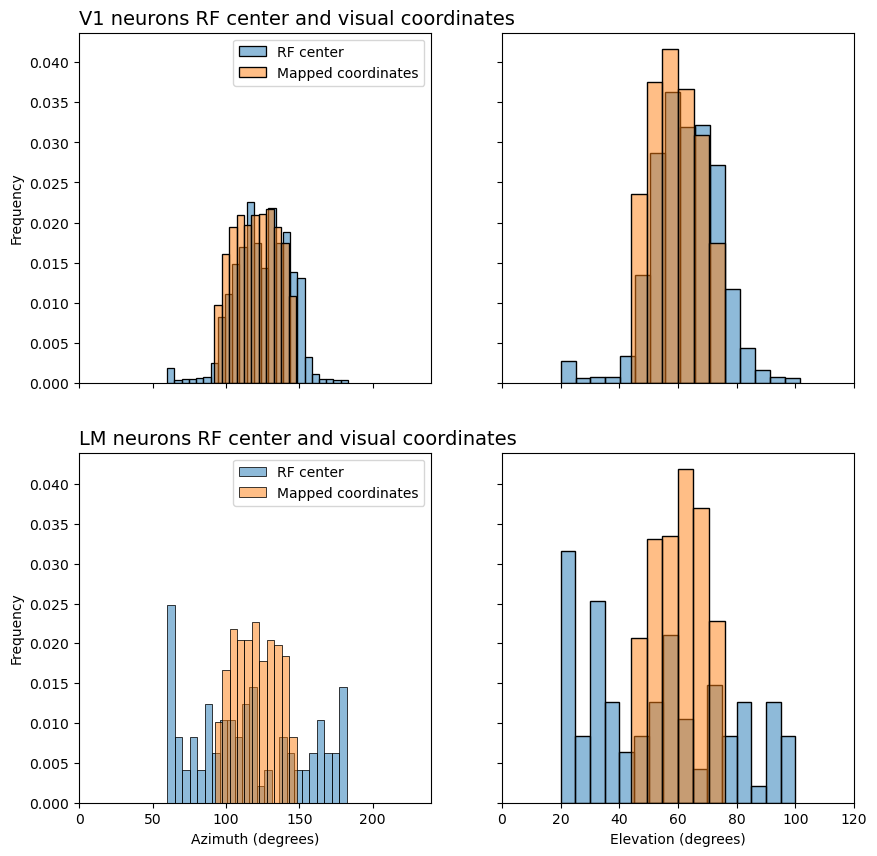

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col')
axs = axs.flatten()

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(df_v1_dis['RF_center_azimuth'], binwidth=5, ax=axs[0], alpha=0.5, label='RF center', stat='density')
sns.histplot(df_v1['Mapped_azimuth'], binwidth=5, ax=axs[0], alpha=0.5, label='Mapped coordinates', stat='density')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(df_v1_dis['RF_center_elevation'], binwidth=5, ax=axs[1], alpha=0.5, stat='density')
sns.histplot(df_v1['Mapped_elevation'], binwidth=5, ax=axs[1], alpha=0.5, stat='density')
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
axs[0].set_title('V1 neurons RF center and visual coordinates', fontsize=14, loc='left')

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(df_lm_dis['RF_center_azimuth'], binwidth=5, ax=axs[2], alpha=0.5, label='RF center', stat='density')
sns.histplot(df_lm['Mapped_azimuth'], binwidth=5, ax=axs[2], alpha=0.5, label='Mapped coordinates', stat='density')
axs[2].set_xlabel('Azimuth (degrees)')
axs[2].set_ylabel('Frequency')
axs[2].set_xlim(0, 240)
axs[2].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(df_lm_dis['RF_center_elevation'], binwidth=5, ax=axs[3], alpha=0.5, stat='density')
sns.histplot(df_lm['Mapped_elevation'], binwidth=5, ax=axs[3], alpha=0.5, stat='density')
axs[3].set_xlabel('Elevation (degrees)')
axs[3].set_ylabel('Frequency')
axs[3].set_xlim(0, 120)

# set title
axs[2].set_title('LM neurons RF center and visual coordinates', fontsize=14, loc='left')
# fig.suptitle('LM neurons RF center and visual coordinates', fontsize=16)

# save the figure
plt.savefig(os.path.join(DISCONNECTED_RESULTS_PATH, 'Receptive_field/rf_centers.png'))


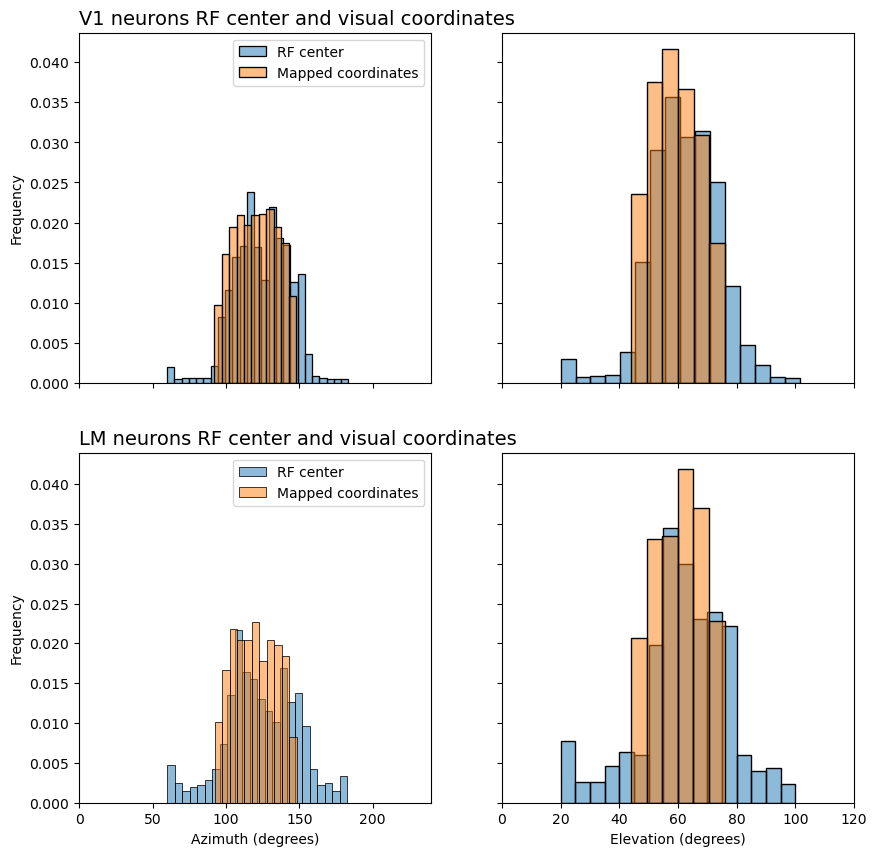

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col')
axs = axs.flatten()

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(df_v1['RF_center_azimuth'], binwidth=5, ax=axs[0], alpha=0.5, label='RF center', stat='density')
sns.histplot(df_v1['Mapped_azimuth'], binwidth=5, ax=axs[0], alpha=0.5, label='Mapped coordinates', stat='density')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(df_v1['RF_center_elevation'], binwidth=5, ax=axs[1], alpha=0.5, stat='density')
sns.histplot(df_v1['Mapped_elevation'], binwidth=5, ax=axs[1], alpha=0.5, stat='density')
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
axs[0].set_title('V1 neurons RF center and visual coordinates', fontsize=14, loc='left')

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(df_lm['RF_center_azimuth'], binwidth=5, ax=axs[2], alpha=0.5, label='RF center', stat='density')
sns.histplot(df_lm['Mapped_azimuth'], binwidth=5, ax=axs[2], alpha=0.5, label='Mapped coordinates', stat='density')
axs[2].set_xlabel('Azimuth (degrees)')
axs[2].set_ylabel('Frequency')
axs[2].set_xlim(0, 240)
axs[2].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(df_lm['RF_center_elevation'], binwidth=5, ax=axs[3], alpha=0.5, stat='density')
sns.histplot(df_lm['Mapped_elevation'], binwidth=5, ax=axs[3], alpha=0.5, stat='density')
axs[3].set_xlabel('Elevation (degrees)')
axs[3].set_ylabel('Frequency')
axs[3].set_xlim(0, 120)

# set title
axs[2].set_title('LM neurons RF center and visual coordinates', fontsize=14, loc='left')
# fig.suptitle('LM neurons RF center and visual coordinates', fontsize=16)

plt.savefig(os.path.join(CONNECTED_RESULTS_PATH, 'Receptive_field/rf_centers.png'))

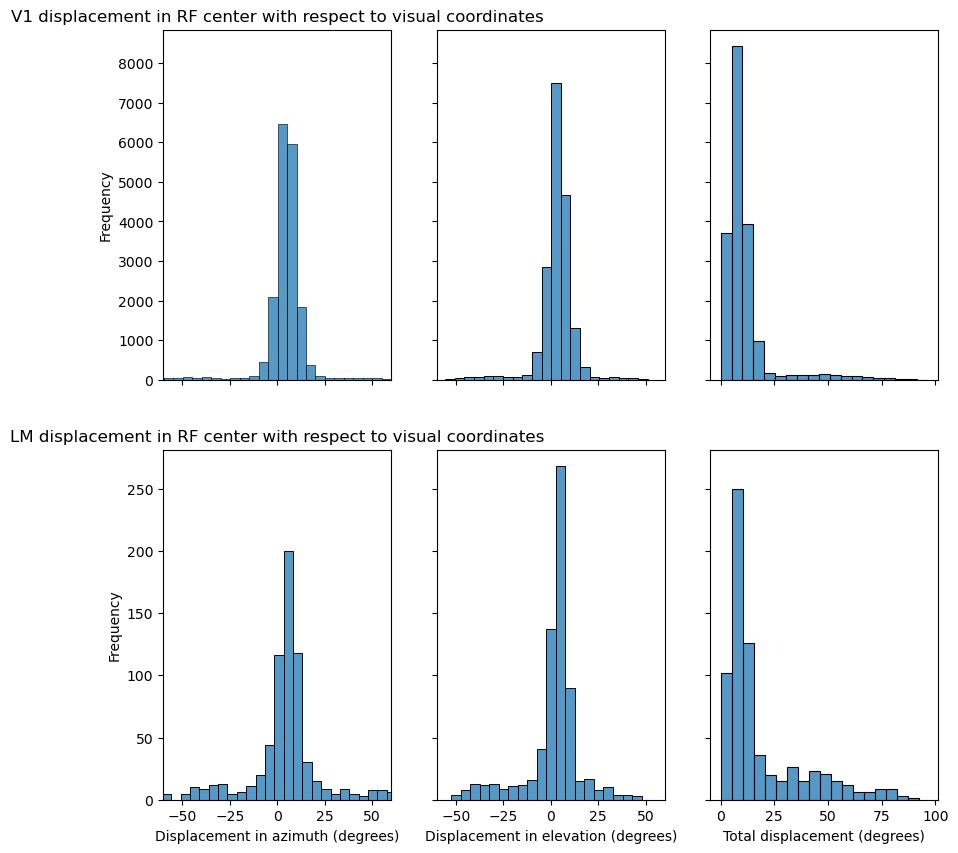

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10), sharey='row', sharex='col')
axs = axs.flatten()

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = df_v1['RF_center_azimuth'] - df_v1['Mapped_azimuth']
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[0])
axs[0].set_xlabel('Displacement in azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = df_v1['RF_center_elevation'] - df_v1['Mapped_elevation']
sns.histplot(displacement_elevation, binwidth=5, ax=axs[1])
axs[1].set_xlabel('Displacement in elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[2])
axs[2].set_xlabel('Total displacement (degrees)')
axs[2].set_ylabel('Frequency')

axs[0].set_title('V1 displacement in RF center with respect to visual coordinates', fontsize=12)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = df_lm['RF_center_azimuth'] - df_lm['Mapped_azimuth']
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[3])
axs[3].set_xlabel('Displacement in azimuth (degrees)')
axs[3].set_ylabel('Frequency')
axs[3].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = df_lm['RF_center_elevation'] - df_lm['Mapped_elevation']
sns.histplot(displacement_elevation, binwidth=5, ax=axs[4])
axs[4].set_xlabel('Displacement in elevation (degrees)')
axs[4].set_ylabel('Frequency')
axs[4].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[5])
axs[5].set_xlabel('Total displacement (degrees)')
axs[5].set_ylabel('Frequency')

axs[3].set_title('LM displacement in RF center with respect to visual coordinates', fontsize=12)
plt.savefig(os.path.join(CONNECTED_RESULTS_PATH, 'Receptive_field/rf_center_displacement.png'))
plt.show()

In [29]:
non_significant_neurons_v1 = df_v1[~df_v1['RF_area'].isnull()]['node_id']
non_significant_neurons_v1_dis = df_v1_dis[~df_v1_dis['RF_area'].isnull()]['node_id']
# find the common neurons between the two lists
common_neurons = np.intersect1d(non_significant_neurons_v1, non_significant_neurons_v1_dis)
print(f"Number of neurons with significant RF in both networks: {len(common_neurons)}")

Number of neurons with significant RF in both networks: 12755


Mean V1 disconnected RF area: 84.07 ± 0.80 deg^2
Mean V1 RF area: 89.71 ± 0.84 deg^2
Mean LM RF area: 195.54 ± 9.85 deg^2
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

V1 disconnected vs. V1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-23 U_stat=1.739e+08
V1 vs. LM: Mann-Whitney-Wilcoxon test two-sided, P_val:2.044e-170 U_stat=2.474e+06
V1 disconnected vs. LM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.832e-195 U_stat=2.448e+06


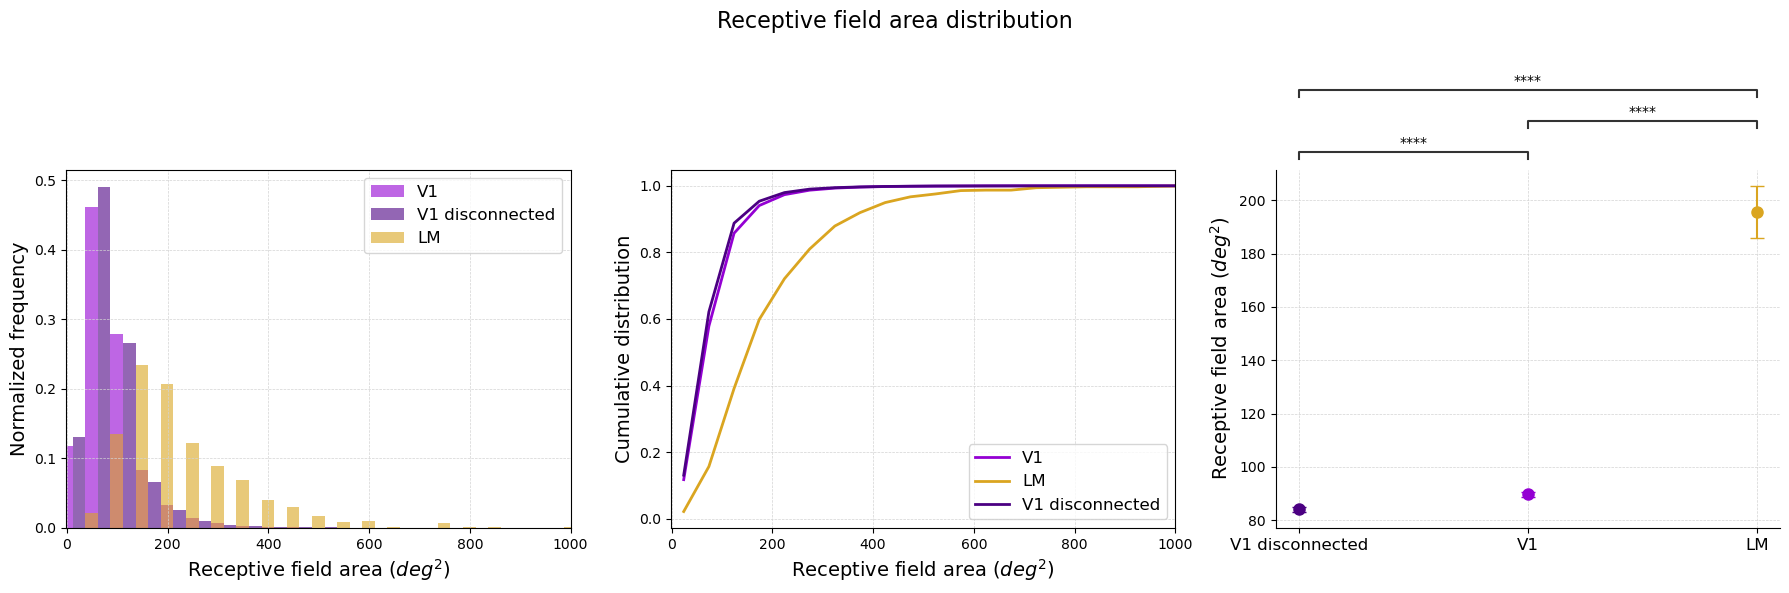

In [30]:
# Constants
BIN_EDGES = np.arange(-1, 100 * 100, 50)
BIN_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2
BAR_WIDTH = (BIN_EDGES[1] - BIN_EDGES[0]) / 2
COLORS = ['indigo', 'darkviolet', 'goldenrod']
GROUPS = ["V1 disconnected", "V1", "LM"]

# # drop the neurons ids that have non-significant receptive field areas in both v1_df and in v1_dis_df 
# df_v1 = df_v1[~df_v1['node_id'].isin(common_neurons)]
# df_v1_dis = df_v1_dis[~df_v1_dis['node_id'].isin(common_neurons)]

# Filter data
rf_areas_v1_significant = df_v1['RF_area'].values
rf_areas_lm_significant = df_lm['RF_area'].values
rf_areas_v1_dis_significant = df_v1_dis['RF_area'].values

# # # replace nan values with 0, since the absence of a significant RF corresponds to a lack of detectable area.
# rf_areas_v1_significant[np.isnan(rf_areas_v1_significant)] = 0
# rf_areas_v1_dis_significant[np.isnan(rf_areas_v1_dis_significant)] = 0
# rf_areas_lm_significant[np.isnan(rf_areas_lm_significant)] = 0

# Compute histograms
hist_v1 = np.histogram(rf_areas_v1_significant, bins=BIN_EDGES)[0]
hist_lm = np.histogram(rf_areas_lm_significant, bins=BIN_EDGES)[0]
hist_v1_dis = np.histogram(rf_areas_v1_dis_significant, bins=BIN_EDGES)[0]

# Normalize histograms
hist_v1 = hist_v1 / hist_v1.sum()
hist_lm = hist_lm / hist_lm.sum()
hist_v1_dis = hist_v1_dis / hist_v1_dis.sum()

# Compute cumulative distributions
cumsum_v1 = np.cumsum(hist_v1)
cumsum_lm = np.cumsum(hist_lm)
cumsum_v1_dis = np.cumsum(hist_v1_dis)

# Compute statistics
def get_bootstrap_95ci(M, measure_of_central_tendency, N=1000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = measure_of_central_tendency(boot)
        
    return np.percentile(est,97.5) - np.nanmean(est)

mean_v1 = np.nanmean(rf_areas_v1_significant)
mean_lm = np.nanmean(rf_areas_lm_significant)
mean_v1_dis = np.nanmean(rf_areas_v1_dis_significant)
ci_v1 = get_bootstrap_95ci(rf_areas_v1_significant, np.nanmean)
ci_lm = get_bootstrap_95ci(rf_areas_lm_significant, np.nanmean)
ci_v1_dis = get_bootstrap_95ci(rf_areas_v1_dis_significant, np.nanmean)
print(f'Mean V1 disconnected RF area: {mean_v1_dis:.2f} ± {ci_v1_dis:.2f} deg^2')
print(f'Mean V1 RF area: {mean_v1:.2f} ± {ci_v1:.2f} deg^2')
print(f'Mean LM RF area: {mean_lm:.2f} ± {ci_lm:.2f} deg^2')

data = pd.DataFrame({
    "Group": ["V1 disconnected"] * len(rf_areas_v1_dis_significant) +
              ["V1"] * len(rf_areas_v1_significant) +
              ["LM"] * len(rf_areas_lm_significant),
    "Value": list(rf_areas_v1_dis_significant) + list(rf_areas_v1_significant) + list(rf_areas_lm_significant)
})

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot histograms
axs[0].bar(BIN_CENTERS - BAR_WIDTH, hist_v1, width=BAR_WIDTH, color='darkviolet', label='V1', alpha=0.6)
axs[0].bar(BIN_CENTERS, hist_v1_dis, width=BAR_WIDTH, color='indigo', label='V1 disconnected', alpha=0.6)
axs[0].bar(BIN_CENTERS + BAR_WIDTH, hist_lm, width=BAR_WIDTH, color='goldenrod', label='LM', alpha=0.6)
# axs[0].plot(BIN_CENTERS, hist_v1, color='darkviolet', linewidth=2)
# axs[0].plot(BIN_CENTERS, hist_lm, color='goldenrod', linewidth=2)
# axs[0].plot(BIN_CENTERS, hist_v1_dis, color='indigo', linewidth=2)
axs[0].set_xlabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[0].set_ylabel('Normalized frequency', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].set_xlim(-1, 1000)
axs[0].grid(color='lightgrey', linestyle='--', linewidth=0.5)

# Plot cumulative distributions
axs[1].plot(BIN_CENTERS, cumsum_v1, color='darkviolet', linewidth=2, label='V1')
axs[1].plot(BIN_CENTERS, cumsum_lm, color='goldenrod', linewidth=2, label='LM')
axs[1].plot(BIN_CENTERS, cumsum_v1_dis, color='indigo', linewidth=2, label='V1 disconnected')
axs[1].set_xlabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[1].set_ylabel('Cumulative distribution', fontsize=14)
axs[1].set_xlim(-1, 1000)
axs[1].grid(color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].legend(fontsize=12)

# Plot means with error bars and annotations
means = [mean_v1_dis, mean_v1, mean_lm]
errors = [ci_v1_dis, ci_v1, ci_lm]
for i, group in enumerate(GROUPS):
    axs[2].errorbar(group, means[i], yerr=errors[i], fmt='o', capsize=5, markersize=8, color=COLORS[i])

pairs = [("V1 disconnected", "V1"), ("V1", "LM"), ("V1 disconnected", "LM")]
annotator = Annotator(axs[2], pairs, data=data, x="Group", y="Value")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside", verbose=2)
annotator.apply_and_annotate()

axs[2].set_ylabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[2].grid(color='lightgrey', linestyle='--', linewidth=0.5)
axs[2].spines['right'].set_color('none')
axs[2].spines['top'].set_color('none')
axs[2].set_xticks(range(len(GROUPS)))
axs[2].set_xticklabels(GROUPS, fontsize=12)

fig.suptitle(f'Receptive field area distribution', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'rf_area_distribution.png'))
plt.show()

In [31]:
# Mean V1 disconnected RF area: 135.06 ± 0.65 deg^2
# Mean V1 RF area: 139.47 ± 0.69 deg^2
# Mean LM RF area: 199.17 ± 4.57 deg^2

### CELL TYPE RF ANALYSIS

Mean V1 L5 Exc disconnected RF area: 100.27 ± 2.89 deg^2
Mean V1 L5 Exc RF area: 99.59 ± 2.84 deg^2
Mean LM L5 Exc RF area: 170.52 ± 22.63 deg^2
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

V1 disconnected vs. V1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.987e-01 U_stat=1.501e+06
V1 vs. LM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.198e-13 U_stat=2.634e+04
V1 disconnected vs. LM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.154e-13 U_stat=2.993e+04


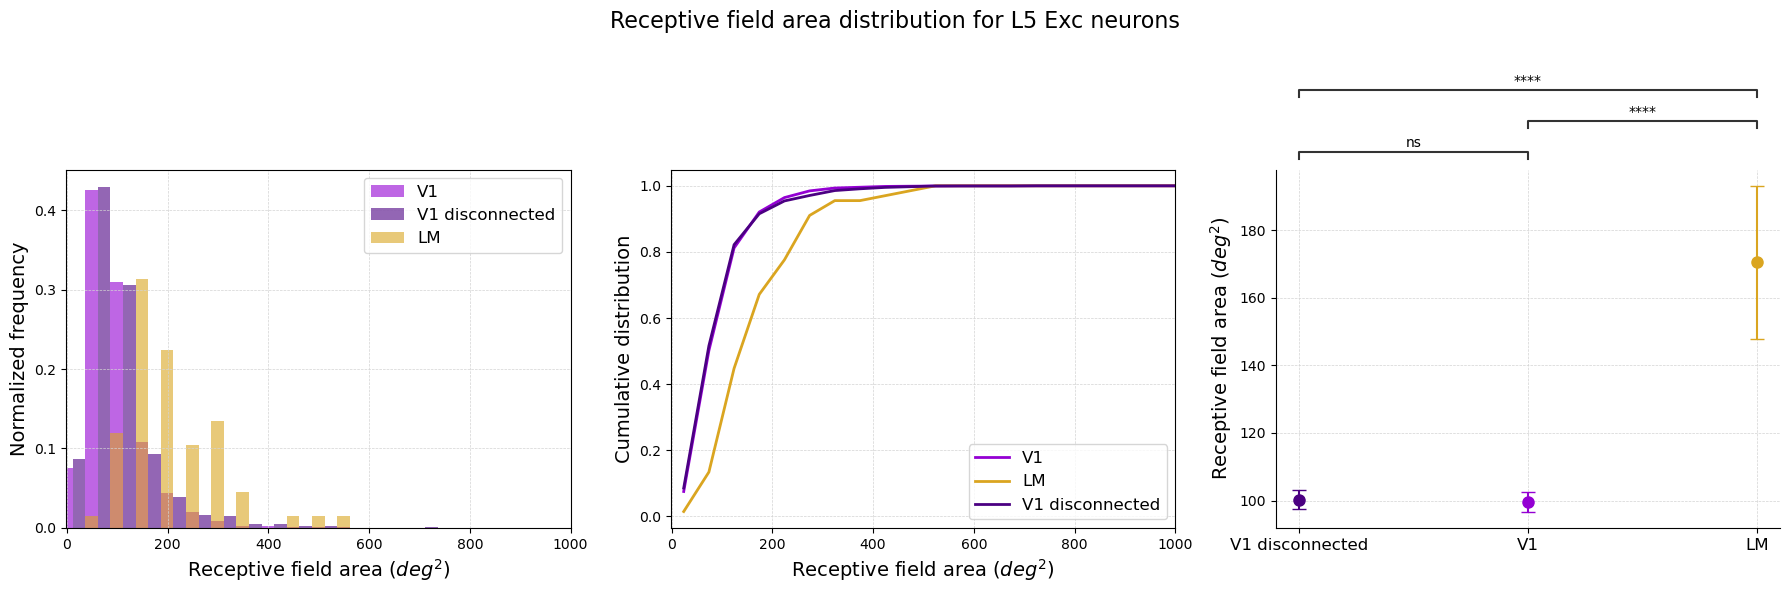

In [32]:
# Constants
CELL_TYPE = 'L5 Exc'
BIN_EDGES = np.arange(-1, 100 * 100, 50)
BIN_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2
BAR_WIDTH = (BIN_EDGES[1] - BIN_EDGES[0]) / 2
COLORS = ['indigo', 'darkviolet', 'goldenrod']
GROUPS = ["V1 disconnected", "V1", "LM"]

# Filter data picking up only from cell types equal to CELL_TYPE
rf_areas_v1_significant = df_v1[df_v1['cell_type']==CELL_TYPE]['RF_area'].values
rf_areas_lm_significant = df_lm[df_lm['cell_type']==CELL_TYPE]['RF_area'].values
rf_areas_v1_dis_significant = df_v1_dis[df_v1_dis['cell_type']==CELL_TYPE]['RF_area'].values

# # replace nan values with 0, since the absence of a significant RF corresponds to a lack of detectable area.
# rf_areas_v1_significant[np.isnan(rf_areas_v1_significant)] = 0
# rf_areas_lm_significant[np.isnan(rf_areas_lm_significant)] = 0
# rf_areas_v1_dis_significant[np.isnan(rf_areas_v1_dis_significant)] = 0

# Compute histograms
hist_v1 = np.histogram(rf_areas_v1_significant, bins=BIN_EDGES)[0]
hist_lm = np.histogram(rf_areas_lm_significant, bins=BIN_EDGES)[0]
hist_v1_dis = np.histogram(rf_areas_v1_dis_significant, bins=BIN_EDGES)[0]

# Normalize histograms
hist_v1 = hist_v1 / hist_v1.sum()
hist_lm = hist_lm / hist_lm.sum()
hist_v1_dis = hist_v1_dis / hist_v1_dis.sum()

# Compute cumulative distributions
cumsum_v1 = np.cumsum(hist_v1)
cumsum_lm = np.cumsum(hist_lm)
cumsum_v1_dis = np.cumsum(hist_v1_dis)

# Compute statistics
mean_v1 = np.nanmean(rf_areas_v1_significant)
mean_lm = np.nanmean(rf_areas_lm_significant)
mean_v1_dis = np.nanmean(rf_areas_v1_dis_significant)
ci_v1 = get_bootstrap_95ci(rf_areas_v1_significant, np.nanmean)
ci_lm = get_bootstrap_95ci(rf_areas_lm_significant, np.nanmean)
ci_v1_dis = get_bootstrap_95ci(rf_areas_v1_dis_significant, np.nanmean)
print(f'Mean V1 {CELL_TYPE} disconnected RF area: {mean_v1_dis:.2f} ± {ci_v1_dis:.2f} deg^2')
print(f'Mean V1 {CELL_TYPE} RF area: {mean_v1:.2f} ± {ci_v1:.2f} deg^2')
print(f'Mean LM {CELL_TYPE} RF area: {mean_lm:.2f} ± {ci_lm:.2f} deg^2')

data = pd.DataFrame({
    "Group": ["V1 disconnected"] * len(rf_areas_v1_dis_significant) +
              ["V1"] * len(rf_areas_v1_significant) +
              ["LM"] * len(rf_areas_lm_significant),
    "Value": list(rf_areas_v1_dis_significant) + list(rf_areas_v1_significant) + list(rf_areas_lm_significant)
})

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot histograms
axs[0].bar(BIN_CENTERS - BAR_WIDTH, hist_v1, width=BAR_WIDTH, color='darkviolet', label='V1', alpha=0.6)
axs[0].bar(BIN_CENTERS, hist_v1_dis, width=BAR_WIDTH, color='indigo', label='V1 disconnected', alpha=0.6)
axs[0].bar(BIN_CENTERS + BAR_WIDTH, hist_lm, width=BAR_WIDTH, color='goldenrod', label='LM', alpha=0.6)
# axs[0].plot(BIN_CENTERS, hist_v1, color='darkviolet', linewidth=2)
# axs[0].plot(BIN_CENTERS, hist_lm, color='goldenrod', linewidth=2)
# axs[0].plot(BIN_CENTERS, hist_v1_dis, color='indigo', linewidth=2)
axs[0].set_xlabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[0].set_ylabel('Normalized frequency', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].set_xlim(-1, 1000)
axs[0].grid(color='lightgrey', linestyle='--', linewidth=0.5)

# Plot cumulative distributions
axs[1].plot(BIN_CENTERS, cumsum_v1, color='darkviolet', linewidth=2, label='V1')
axs[1].plot(BIN_CENTERS, cumsum_lm, color='goldenrod', linewidth=2, label='LM')
axs[1].plot(BIN_CENTERS, cumsum_v1_dis, color='indigo', linewidth=2, label='V1 disconnected')
axs[1].set_xlabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[1].set_ylabel('Cumulative distribution', fontsize=14)
axs[1].set_xlim(-1, 1000)
axs[1].grid(color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].legend(fontsize=12)

# Plot means with error bars and annotations
means = [mean_v1_dis, mean_v1, mean_lm]
errors = [ci_v1_dis, ci_v1, ci_lm]
for i, group in enumerate(GROUPS):
    axs[2].errorbar(group, means[i], yerr=errors[i], fmt='o', capsize=5, markersize=8, color=COLORS[i])

pairs = [("V1 disconnected", "V1"), ("V1", "LM"), ("V1 disconnected", "LM")]
annotator = Annotator(axs[2], pairs, data=data, x="Group", y="Value")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside", verbose=2)
annotator.apply_and_annotate()

axs[2].set_ylabel(r'Receptive field area ($deg^2$)', fontsize=14)
axs[2].grid(color='lightgrey', linestyle='--', linewidth=0.5)
axs[2].spines['right'].set_color('none')
axs[2].spines['top'].set_color('none')
axs[2].set_xticks(range(len(GROUPS)))
axs[2].set_xticklabels(GROUPS, fontsize=12)

fig.suptitle(f'Receptive field area distribution for {CELL_TYPE} neurons', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, f'rf_{CELL_TYPE}_distribution.png'))
plt.show()

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


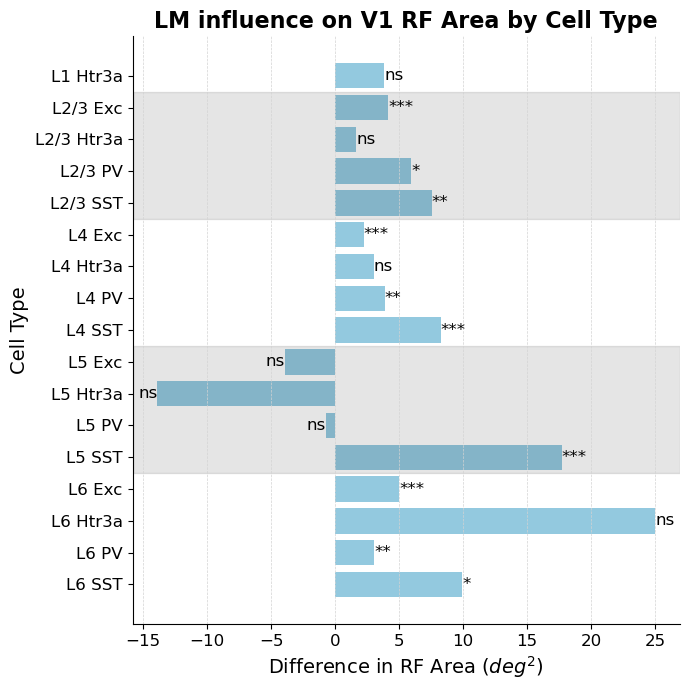

In [33]:
# copy the original df
df_areas_v1 = df_v1.copy()
df_areas_v1_dis = df_v1_dis.copy()

# # # # # replace nan values with 0, since the absence of a significant RF corresponds to a lack of detectable area.
# df_areas_v1['RF_area'][df_areas_v1['RF_area'].isnull()] = 0
# df_areas_v1_dis['RF_area'][df_areas_v1_dis['RF_area'].isnull()] = 0
# Get the receptive fields areas
rf_areas_v1 = df_areas_v1.dropna(subset=['RF_area'])[['node_id', 'cell_type', 'RF_area']]
rf_areas_v1_dis = df_areas_v1_dis.dropna(subset=['RF_area'])[['node_id', 'cell_type', 'RF_area']]

# Merge data to calculate differences
differences = rf_areas_v1.merge(rf_areas_v1_dis, on=['node_id', 'cell_type'], suffixes=('_v1', '_v1_dis'))
# drop the rows where the rf was 0 for the two conditions
# differences = differences[(differences['RF_area_v1'] > 0) | (differences['RF_area_v1_dis'] > 0)]
differences['Difference'] = differences['RF_area_v1'] - differences['RF_area_v1_dis']

# Calculate mean difference for each cell type and perform statistical tests
mean_differences = differences.groupby('cell_type')['Difference'].mean().reset_index()
# p_values = differences.groupby('cell_type')['Difference'].apply(lambda x: wilcoxon(x, zero_method='wilcox', correction=True).pvalue if len(x) > 0 else np.nan).reset_index(name='p_value')

# Perform Wilcoxon test and handle cases with all zero differences
def safe_wilcoxon(x):
    if len(x) == 0:
        return np.nan
    elif np.all(x == 0):
        return 1.0
    else:
        return wilcoxon(x, zero_method='wilcox', correction=True).pvalue

p_values = differences.groupby('cell_type')['Difference'].apply(safe_wilcoxon).reset_index(name='p_value')

results = mean_differences.merge(p_values, on='cell_type')

# Annotate significance levels
def significance_annotation(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

results['Significance'] = results['p_value'].apply(significance_annotation)

# Define layer boundaries for shading
layer_boundaries = [0, 1, 5, 9, 13]  # Example indices for layer breaks

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(
    data=results,
    y='cell_type',
    x='Difference',
    color='skyblue',
    ax=ax
)

# Add significance annotations
for i, row in results.iterrows():
    ax.text(
        row['Difference'], i,
        f"{row['Significance']}",
        color='black',
        ha='left' if row['Difference'] >= 0 else 'right',
        va='center',
        fontsize=12
    )

# Add shading for layers
for i in range(len(layer_boundaries) - 1):
    if i % 2 == 1:  # Shade every other layer
        ax.axhspan(
            layer_boundaries[i]-0.5, layer_boundaries[i + 1] - 0.5,
            color='black', alpha=0.1
        )

# Enhance the aesthetics
ax.set_xlabel('Difference in RF Area ($deg^2$)', fontsize=14)
ax.set_ylabel('Cell Type', fontsize=14)
ax.set_title('LM influence on V1 RF Area by Cell Type', fontsize=16, weight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='x', color='lightgrey', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'lm_influence_on_v1_rf_area.png'))
plt.show()

In [34]:
# create a new column called preferred_number and for every neuron in the list assign the number of the preferred stimulus
for mnist_number in range(10):
    ids = networks['v1'][f'readout_neuron_ids_{mnist_number}'][0]
    df_v1.loc[df_v1['node_id'].isin(ids), 'Preferred_number'] = str(mnist_number)
    df_v1_dis.loc[df_v1_dis['node_id'].isin(ids), 'Preferred_number'] = str(mnist_number)

# Prepare data for calculating differences
rf_areas_v1 = df_v1.dropna(subset=['RF_area'])[['node_id', 'Preferred_number', 'RF_area']]
rf_areas_v1_dis = df_v1_dis.dropna(subset=['RF_area'])[['node_id', 'Preferred_number', 'RF_area']]

# Find common neurons using 'node_id'
common_node_ids = set(rf_areas_v1['node_id']).intersection(set(rf_areas_v1_dis['node_id']))
rf_areas_v1 = rf_areas_v1[rf_areas_v1['node_id'].isin(common_node_ids)]
rf_areas_v1_dis = rf_areas_v1_dis[rf_areas_v1_dis['node_id'].isin(common_node_ids)]

# Merge data to calculate differences
differences = rf_areas_v1.merge(rf_areas_v1_dis, on=['node_id', 'Preferred_number'], suffixes=('_v1', '_v1_dis'))
differences['Difference'] = differences['RF_area_v1'] - differences['RF_area_v1_dis']

# Calculate mean difference for each cell type and perform statistical tests
mean_differences = differences.groupby('Preferred_number')['Difference'].mean().reset_index()
p_values = differences.groupby('Preferred_number')['Difference'].apply(lambda x: wilcoxon(x, zero_method='wilcox', correction=True).pvalue if len(x) > 0 else np.nan).reset_index(name='p_value')
results = mean_differences.merge(p_values, on='Preferred_number')

# Annotate significance levels
def significance_annotation(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

results['Significance'] = results['p_value'].apply(significance_annotation)

# Create horizontal bar plot
# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(
    data=results,
    y='Preferred_number',  # Switch x and y
    x='Difference',  # Switch x and y
    color='skyblue',
    ax=ax
)

# # Add significance annotations
# for i, row in results.iterrows():
#     ax.text(
#         row['Difference'], i,
#         f"{row['Significance']}",
#         color='black',
#         ha='left' if row['Difference'] >= 0 else 'right',
#         va='center',
#         fontsize=12
#     )

# Enhance the aesthetics
ax.set_xlabel('Mean Difference in RF Area ($deg^2$)', fontsize=14)
ax.set_ylabel('Preferred_number', fontsize=14)
ax.set_title('LM influence on V1 RF Area by Preferred_number', fontsize=16, weight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='x', color='lightgrey', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [31]:
differences

,node_id,Preferred_number,RF_area_v1,RF_area_v1_dis,Difference
0,0,NaN,100.0,200.0,-100.0
1,1,NaN,400.0,400.0,0.0
2,2,NaN,400.0,300.0,100.0
3,3,NaN,100.0,100.0,0.0
4,4,NaN,100.0,100.0,0.0
...,...,...,...,...,...
28223,51966,NaN,100.0,100.0,0.0
28224,51967,NaN,100.0,100.0,0.0
28225,51971,NaN,100.0,100.0,0.0
28226,51973,NaN,100.0,100.0,0.0
